In [1]:
import pandas as pd
import numpy as np
import sklearn as sk
import urllib
import math
import matplotlib as plt
%pylab inline

import findspark
findspark.init()

from pyspark import SparkContext
#sc.stop()
sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/spark_PCA.py','lib/computeStats.py'])

from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)

import sys
sys.path.append('./lib')

from numpy_pack import packArray,unpackArray
from spark_PCA import computeCov
from computeStats import computeOverAllDist, STAT_Descriptions

Populating the interactive namespace from numpy and matplotlib


/Users/RaphaelLu/anaconda2/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
### Read the data frame from pickle file

data_dir='../../Data/Weather'
file_index='BSSSBSBB'
from pickle import load

#read statistics
filename=data_dir+'/STAT_%s.pickle'%file_index
STAT,STAT_Descriptions = load(open(filename,'rb'))
print 'keys from STAT=',STAT.keys()

#read data
filename=data_dir+'/US_Weather_%s.parquet'%file_index

df=sqlContext.read.parquet(filename)
print df.count()
df.show(5)

keys from STAT= ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP']
12816
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|     78.3| 32.5906| -86.2103|       TMAX|USC00018859|     1|[C8 5A E8 59 F0 5...|1897.0|BSSSBSBB|
|     78.3| 32.5906| -86.2103|       TMAX|USC00018859|     0|[80 58 00 00 20 5...|1898.0|BSSSBSBB|
|     78.3| 32.5906| -86.2103|       TMAX|USC00018859|     0|[60 59 00 53 40 5...|1899.0|BSSSBSBB|
|     78.3| 32.5906| -86.2103|       TMAX|USC00018859|     6|[00 C6 00 4F 00 4...|1900.0|BSSSBSBB|
|     78.3| 32.5906| -86.2103|       TMAX|USC00018859|     0|[28 58 40 56 30 5...|1901.0|BSSSBSBB|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
only showing top 5 rows



In [111]:
sqlContext.registerDataFrameAsTable(df,'weather')
Query="SELECT * FROM weather\n\tWHERE measurement='%s'"%('PRCP')
print Query
df1 = sqlContext.sql(Query)
print df1.count(),'rows'
#df1.show(10)
rows=df1.rdd.map(lambda row: (row['year'], np.nansum(unpackArray(row['vector'],np.float16))))
low_yr = df1.rdd.map(lambda row:(row['year'])).reduce(lambda a,b : min(a,b))
high_yr = df1.rdd.map(lambda row:(row['year'])).reduce(lambda a,b : max(a,b))
print high_yr, low_yr
year_prcp = rows.reduceByKey(lambda a,b: nanmean(np.array(a,b))).sortByKey().map(lambda a: a[1]/10.)
print year_prcp.count()
year_prcp = year_prcp.collect()
print year_prcp
# T=np.vstack(rows)
# shape(T)

SELECT * FROM weather
	WHERE measurement='PRCP'
3337 rows
2012.0 1873.0
140
[1462.4000000000001, 1201.5999999999999, 1392.8, 1366.4000000000001, 1180.8, 1320.0, 1146.4000000000001, 1292.8, 1279.2, 1314.4000000000001, 922.39999999999998, 1144.0, 1496.8, 1336.0, 1136.8, 1209.5999999999999, 1079.2, 1136.0, 1296.8, 1246.4000000000001, 1206.4000000000001, 1056.8, 1132.8, 1177.5999999999999, 1036.0, 1142.4000000000001, 1144.8, 1489.5999999999999, 1077.5999999999999, 1072.8, 1245.5999999999999, 1099.2, 1074.4000000000001, 1324.8, 1365.5999999999999, 1010.4, 1220.0, 1036.8, 1306.4000000000001, 1584.8, 1120.8, 1068.8, 1046.4000000000001, 1061.5999999999999, 1101.5999999999999, 1273.5999999999999, 1499.2, 1505.5999999999999, 1043.2, 1161.5999999999999, 1416.0, 1095.2, 1237.5999999999999, 1466.4000000000001, 867.20000000000005, 1411.2, 1768.0, 1022.4, 860.79999999999995, 1200.8, 1034.4000000000001, 1232.8, 1143.2, 1347.2, 1326.4000000000001, 1140.0, 1132.0, 1288.8, 1337.5999999999999, 1473.599999

## Plot yearly total PRCP

In [96]:
def plot_year_prcp(year_prcp, low_yr, high_yr, fig, ax, color):
    indices = [i for i in range(int(low_yr), int(high_yr) + 1)]
    plt.plot(indices, year_prcp, color)
    fig.autofmt_xdate()
    ax.grid()
    ax.set_title('yearly total PRCP')

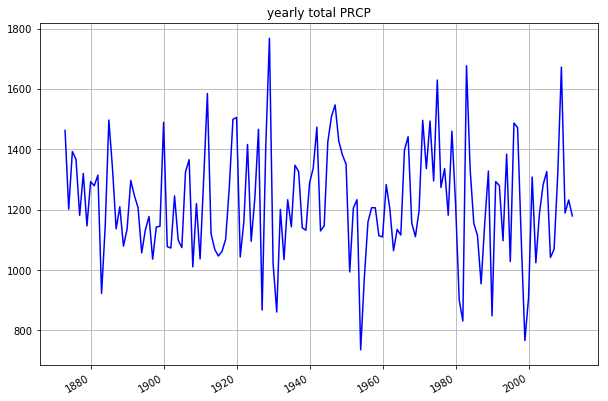

In [97]:
fig, ax = plt.subplots(figsize=(10,7))
plot_year_prcp(year_prcp, low_yr, high_yr, fig, ax, 'b-')

It looks that every once a while there is a drought - let's quantify drought condition with Rainfall Variability Index (RVI) [1]: 

*[1] Yuhu Zhang, Wanyuan Cai, Qiuhua Chen, Yunjun Yao, and Kaili Liu, “Analysis of Changes in Precipitation and Drought in Aksu River Basin, Northwest China,” Advances in Meteorology, vol. 2015, Article ID 215840, 15 pages, 2015. doi:10.1155/2015/215840 *

In [98]:
def estimateDrought(P, mean, std):
    if P < mean - 2 * std:
        return "extremely dry"
    elif P > mean - 2 * std and P < mean - std:
        return "dry"
    elif P > mean - std and P < mean + std:
        return "normal"
    elif P > mean + std:
        return "wet"

def calRVI(ary, mean, stddev):
    res = []
    for i in range(0, len(ary)):
        rvi = (ary[i]-mean)/stddev
        res.append(rvi)
    return res

mean = np.mean(np.array(year_prcp), dtype=np.float64)
stddev = np.std(np.array(year_prcp), dtype=np.float64)
print mean
print stddev

drought_years = []
year_prcp_rvi = calRVI(year_prcp, mean,stddev)
for i in range(0, len(year_prcp_rvi)):
    rvi = year_prcp_rvi[i]
    if rvi < 0:
        condition = estimateDrought(year_prcp[i], mean, stddev)
        if condition == 'extremely dry' or condition == 'dry':
            print (low_yr + i), condition 
            drought_years.append(int(low_yr + i))

1221.93428571
187.341165399
1883.0 dry
1908.0 dry
1927.0 dry
1930.0 dry
1931.0 dry
1933.0 dry
1951.0 dry
1954.0 extremely dry
1955.0 dry
1981.0 dry
1982.0 extremely dry
1987.0 dry
1990.0 dry
1995.0 dry
1999.0 extremely dry
2000.0 dry
2002.0 dry


### replot the graph with RVI as y-axis


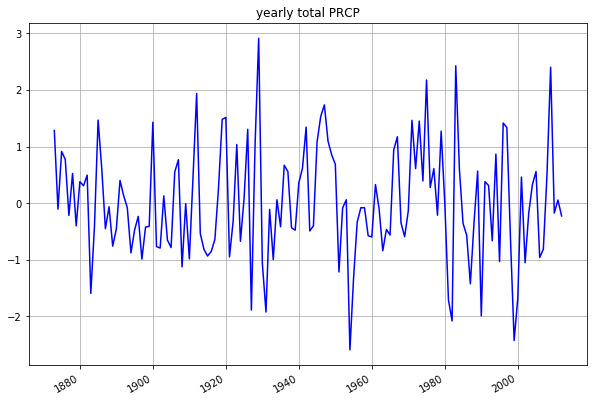

In [99]:
fig, ax = plt.subplots(figsize=(10,7))
plot_year_prcp(year_prcp_rvi, low_yr, high_yr, fig, ax, 'b-')

### Residual plot


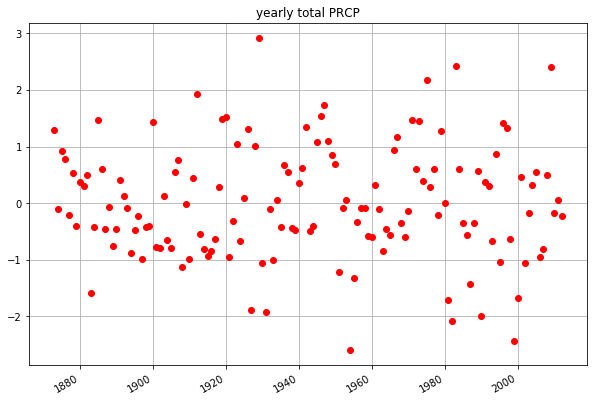

In [100]:
fig, ax = plt.subplots(figsize=(10,7))
plot_year_prcp(year_prcp_rvi, low_yr, high_yr, fig, ax, 'ro')

### linear regression model

/Users/RaphaelLu/anaconda2/lib/python2.7/site-packages/numpy/lib/polynomial.py:595: RankWarning: Polyfit may be poorly conditioned
  warnings.warn(msg, RankWarning)


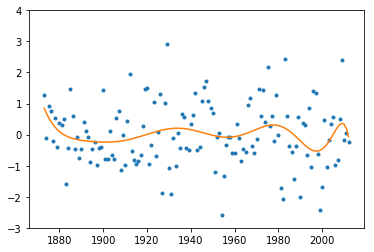

In [101]:
years = [i for i in range(int(low_yr), int(high_yr)+1)]
z = np.polyfit(years, year_prcp_rvi, 50)

p = np.poly1d(z)

_ = plt.plot(years, year_prcp_rvi, '.', years, p(years), '-')
plt.ylim(-3,4)
plt.show()

### Summer and Winter droughts

In [102]:
print "======================= summer droughts ======================="
rows=df1.rdd.map(lambda row: (row['year'], np.nansum(unpackArray(row['vector'],np.float16)[150:241])))
summer_prcp = rows.reduceByKey(lambda a,b: nanmean(np.array(a,b))).sortByKey().map(lambda a: a[1]/10.)
summer_prcp = summer_prcp.collect()
# rvi
mean = np.mean(np.array(summer_prcp), dtype=np.float64)
stddev = np.std(np.array(summer_prcp), dtype=np.float64)

summer_prcp_rvi = calRVI(summer_prcp, mean, stddev)
summer_drought_years = []
for i in range(0, len(summer_prcp_rvi)):
    rvi = summer_prcp_rvi[i]
    if rvi < 0:
        condition = estimateDrought(summer_prcp[i], mean, stddev)
        if condition == 'extremely dry' or condition == 'dry':
            print (low_yr + i), condition 
            summer_drought_years.append(int(low_yr + i))
                       
print "======================= winter droughts ======================="
rows=df1.rdd.map(lambda row: (row['year'], np.nansum(np.concatenate([unpackArray(row['vector'],np.float16)[:61],unpackArray(row['vector'],np.float16)[335:]]))))
winter_prcp = rows.reduceByKey(lambda a,b: nanmean(np.array(a,b))).sortByKey().map(lambda a: a[1]/10.)
winter_prcp = winter_prcp.collect()
# rvi
mean = np.mean(np.array(winter_prcp), dtype=np.float64)
stddev = np.std(np.array(winter_prcp), dtype=np.float64)

winter_prcp_rvi = calRVI(winter_prcp, mean, stddev)
winter_drought_years = []
for i in range(0, len(winter_prcp_rvi)):
    rvi = winter_prcp_rvi[i]
    if rvi < 0:
        condition = estimateDrought(winter_prcp[i], mean, stddev)
        if condition == 'extremely dry' or condition == 'dry':
            print (low_yr + i), condition 
            winter_drought_years.append(int(low_yr + i))

======================= summer droughts =======================
1875.0 dry
1877.0 dry
1880.0 dry
1883.0 dry
1888.0 dry
1902.0 extremely dry
1909.0 dry
1915.0 dry
1922.0 dry
1929.0 dry
1931.0 dry
1951.0 dry
1954.0 dry
1955.0 dry
1959.0 dry
1976.0 dry
1980.0 dry
1981.0 dry
1986.0 dry
1987.0 dry
1988.0 dry
1990.0 dry
1995.0 dry
1999.0 dry
2000.0 dry
2002.0 dry
2006.0 dry
======================= winter droughts =======================
1890.0 dry
1893.0 dry
1896.0 dry
1898.0 dry
1914.0 dry
1921.0 dry
1928.0 dry
1930.0 dry
1934.0 dry
1938.0 dry
1951.0 dry
1954.0 dry
1957.0 dry
1958.0 dry
1980.0 dry
1982.0 dry
1986.0 dry
1996.0 dry
1999.0 dry
2000.0 dry


### Plot summer and winter drought years

drought years: [1883, 1908, 1927, 1930, 1931, 1933, 1951, 1954, 1955, 1981, 1982, 1987, 1990, 1995, 1999, 2000, 2002]
summer drought years: [1875, 1877, 1880, 1883, 1888, 1902, 1909, 1915, 1922, 1929, 1931, 1951, 1954, 1955, 1959, 1976, 1980, 1981, 1986, 1987, 1988, 1990, 1995, 1999, 2000, 2002, 2006]
winter drought years: [1890, 1893, 1896, 1898, 1914, 1921, 1928, 1930, 1934, 1938, 1951, 1954, 1957, 1958, 1980, 1982, 1986, 1996, 1999, 2000]


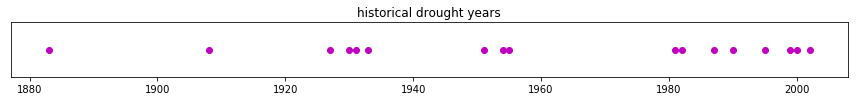

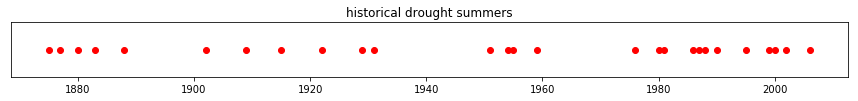

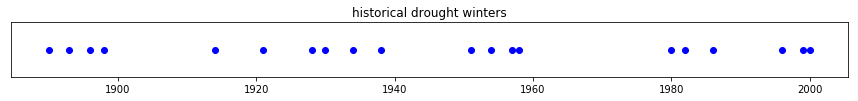

In [103]:
print 'drought years:', drought_years
is_drought = [1 for i in range(0, len(drought_years))]
fig, ax = plt.subplots(figsize=(15,1))
plt.title("historical drought years")
ax.get_yaxis().set_visible(False)
plt.plot(drought_years, is_drought, 'mo')

print 'summer drought years:', summer_drought_years
is_drought = [1 for i in range(0, len(summer_drought_years))]
fig, ax = plt.subplots(figsize=(15,1))
ax.get_yaxis().set_visible(False)
plt.title("historical drought summers")
plt.plot(summer_drought_years, is_drought, 'ro')


print 'winter drought years:', winter_drought_years
is_drought = [1 for i in range(0, len(winter_drought_years))]
fig, ax = plt.subplots(figsize=(15,1))
ax.get_yaxis().set_visible(False)
plt.title("historical drought winters")
plt.plot(winter_drought_years, is_drought, 'bo')

### Correlation between PRCP and TOBS


In [107]:
Query="SELECT * FROM weather\n\tWHERE measurement='%s'"%('TOBS')
print Query
df1 = sqlContext.sql(Query)
print df1.count(),'rows'
#df1.show(10)
rows_tobs=df1.rdd.map(lambda row: (row['year'], np.nansum(unpackArray(row['vector'],np.float16))))
low_yr_TOBS = df1.rdd.map(lambda row:(row['year'])).reduce(lambda a,b : min(a,b))
high_yr_TOBS = df1.rdd.map(lambda row:(row['year'])).reduce(lambda a,b : max(a,b))
print high_yr_TOBS, low_yr_TOBS
year_TOBS = rows.reduceByKey(lambda a,b: nanmean(np.array(a,b))).sortByKey().map(lambda a: a[1]/10.)
print year_TOBS.count()
year_TOBS = year_TOBS.collect()
print year_TOBS
# T=np.vstack(rows)
# shape(T)

SELECT * FROM weather
	WHERE measurement='TOBS'
1303 rows
2012.0 1901.0


Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.collectAndServe.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 1 in stage 246.0 failed 1 times, most recent failure: Lost task 1.0 in stage 246.0 (TID 512, localhost, executor driver): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/Users/RaphaelLu/Downloads/spark-2.1.0-bin-hadoop2.7/python/lib/pyspark.zip/pyspark/worker.py", line 174, in main
    process()
  File "/Users/RaphaelLu/Downloads/spark-2.1.0-bin-hadoop2.7/python/lib/pyspark.zip/pyspark/worker.py", line 169, in process
    serializer.dump_stream(func(split_index, iterator), outfile)
  File "/Users/RaphaelLu/Downloads/spark-2.1.0-bin-hadoop2.7/python/pyspark/rdd.py", line 2407, in pipeline_func
    return func(split, prev_func(split, iterator))
  File "/Users/RaphaelLu/Downloads/spark-2.1.0-bin-hadoop2.7/python/pyspark/rdd.py", line 2407, in pipeline_func
    return func(split, prev_func(split, iterator))
  File "/Users/RaphaelLu/Downloads/spark-2.1.0-bin-hadoop2.7/python/pyspark/rdd.py", line 346, in func
    return f(iterator)
  File "/Users/RaphaelLu/Downloads/spark-2.1.0-bin-hadoop2.7/python/pyspark/rdd.py", line 1828, in combineLocally
    merger.mergeValues(iterator)
  File "/Users/RaphaelLu/Downloads/spark-2.1.0-bin-hadoop2.7/python/lib/pyspark.zip/pyspark/shuffle.py", line 236, in mergeValues
    for k, v in iterator:
  File "<ipython-input-107-ab9308935b72>", line 6, in <lambda>
  File "/private/var/folders/zz/zyxvpxvq6csfxvn_n0000000000000/T/spark-62c5e4e5-2467-4a31-886d-545336f935ee/userFiles-3042d78a-f871-4a7e-a438-394682ab03a3/numpy_pack.py", line 35, in unpackArray
    return np.frombuffer(x,dtype=data_type)
ValueError: buffer size must be a multiple of element size

	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRDD.scala:193)
	at org.apache.spark.api.python.PythonRunner$$anon$1.<init>(PythonRDD.scala:234)
	at org.apache.spark.api.python.PythonRunner.compute(PythonRDD.scala:152)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:63)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:323)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:287)
	at org.apache.spark.api.python.PairwiseRDD.compute(PythonRDD.scala:390)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:323)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:287)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:96)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:53)
	at org.apache.spark.scheduler.Task.run(Task.scala:99)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:282)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1142)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:617)
	at java.lang.Thread.run(Thread.java:745)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1435)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1423)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1422)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1422)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:802)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:802)
	at scala.Option.foreach(Option.scala:257)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:802)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:1650)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1605)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:1594)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:628)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1918)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1931)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1944)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:1958)
	at org.apache.spark.rdd.RDD$$anonfun$collect$1.apply(RDD.scala:935)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:362)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:934)
	at org.apache.spark.api.python.PythonRDD$.collectAndServe(PythonRDD.scala:453)
	at org.apache.spark.api.python.PythonRDD.collectAndServe(PythonRDD.scala)
	at sun.reflect.GeneratedMethodAccessor49.invoke(Unknown Source)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:497)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:280)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:214)
	at java.lang.Thread.run(Thread.java:745)
Caused by: org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/Users/RaphaelLu/Downloads/spark-2.1.0-bin-hadoop2.7/python/lib/pyspark.zip/pyspark/worker.py", line 174, in main
    process()
  File "/Users/RaphaelLu/Downloads/spark-2.1.0-bin-hadoop2.7/python/lib/pyspark.zip/pyspark/worker.py", line 169, in process
    serializer.dump_stream(func(split_index, iterator), outfile)
  File "/Users/RaphaelLu/Downloads/spark-2.1.0-bin-hadoop2.7/python/pyspark/rdd.py", line 2407, in pipeline_func
    return func(split, prev_func(split, iterator))
  File "/Users/RaphaelLu/Downloads/spark-2.1.0-bin-hadoop2.7/python/pyspark/rdd.py", line 2407, in pipeline_func
    return func(split, prev_func(split, iterator))
  File "/Users/RaphaelLu/Downloads/spark-2.1.0-bin-hadoop2.7/python/pyspark/rdd.py", line 346, in func
    return f(iterator)
  File "/Users/RaphaelLu/Downloads/spark-2.1.0-bin-hadoop2.7/python/pyspark/rdd.py", line 1828, in combineLocally
    merger.mergeValues(iterator)
  File "/Users/RaphaelLu/Downloads/spark-2.1.0-bin-hadoop2.7/python/lib/pyspark.zip/pyspark/shuffle.py", line 236, in mergeValues
    for k, v in iterator:
  File "<ipython-input-107-ab9308935b72>", line 6, in <lambda>
  File "/private/var/folders/zz/zyxvpxvq6csfxvn_n0000000000000/T/spark-62c5e4e5-2467-4a31-886d-545336f935ee/userFiles-3042d78a-f871-4a7e-a438-394682ab03a3/numpy_pack.py", line 35, in unpackArray
    return np.frombuffer(x,dtype=data_type)
ValueError: buffer size must be a multiple of element size

	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRDD.scala:193)
	at org.apache.spark.api.python.PythonRunner$$anon$1.<init>(PythonRDD.scala:234)
	at org.apache.spark.api.python.PythonRunner.compute(PythonRDD.scala:152)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:63)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:323)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:287)
	at org.apache.spark.api.python.PairwiseRDD.compute(PythonRDD.scala:390)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:323)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:287)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:96)
	at org.apache.spark.scheduler.ShuffleMapTask.runTask(ShuffleMapTask.scala:53)
	at org.apache.spark.scheduler.Task.run(Task.scala:99)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:282)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1142)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:617)
	... 1 more
